# Analyse des EPOC en Auvergne-Rhône-Alpes
## Mise en place de l'environnement

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
from dynaconf import Dynaconf, Validator
import psycopg2
import pickle

In [2]:
# Drapeaux
GET_FROM_DB = False

# Constantes
EPOC_BUFFER = 200

# Variables d'environment
ENVDIR = Path.home() / ".lpo_atlas_stats"  # Project data directory
DATADIR = ENVDIR / "data"  # Directory for resulting csv files (subdir of ENVDIR)
RESULTDIR = ENVDIR / "result"  # Directory for resulting csv files (subdir of ENVDIR)
CONFIG = ENVDIR / "lpo_aura.toml"  # Configuration file

# Lecture des paramètres de configuration
_settings = Dynaconf(
    settings_files=[CONFIG],
    validators=[
            Validator('db.db_host', must_exist=True),
            Validator('db.db_port', must_exist=True, gt=0),
            Validator('db.db_user', must_exist=True),
            Validator('db.db_password', must_exist=True),
            Validator('db.db_name', must_exist=True),
            Validator('db.db_schema', must_exist=True),
            Validator('sig.departments', must_exist=True),
            Validator('sig.clc', must_exist=True),
            Validator('sig.nom_clc', must_exist=True),
    ]
)

In [3]:
# Lecture du contour des départements
dept = gpd.read_file(DATADIR / _settings.sig.departments).drop(["ID", "NOM_DEP_M"], axis="columns")
dept_aura = dept[dept["INSEE_REG"] == "84"].copy()
dept_aura.set_index('INSEE_DEP', inplace=True)
dept_aura.sort_index(inplace=True)
dept_aura['area'] = dept_aura.area
#dept_aura

In [4]:
# Lecture de Corine Land Cover
clc = gpd.read_file(DATADIR / _settings.sig.clc)
#clc.head()
#clc.plot();

In [5]:
clc_nom = pd.read_csv(DATADIR / _settings.sig.nom_clc, sep=";", usecols=["code_clc_niveau_3", "libelle_fr"]).rename(columns={"code_clc_niveau_3": "CODE_18"}).set_index("CODE_18")

## Lecture des EPOC

Les formulaires contenant le texte "EPOC" sont téléchargés depuis la base AuRA distante et stockés localement pour accélerer les essais.
Pour mettre à jour les EPOC, il faut positionner `GET_FROM_DB = True`

In [6]:
epoc_df = gpd.GeoDataFrame()
if GET_FROM_DB:
    # Read from remote database
    con = psycopg2.connect(
                database=_settings.db.db_name,
                user=_settings.db.db_user,
                password=_settings.db.db_password,
                host=_settings.db.db_host,
                port=_settings.db.db_port,
            )

    sql = "SELECT site, id_form_universal, time_start, time_stop, full_form, version, comments, protocol, geom FROM " + _settings.db.db_schema + ".forms WHERE comments ILIKE '%epoc%'"
    epoc_df = gpd.GeoDataFrame.from_postgis(sql, con, geom_col='geom' )
    with open(RESULTDIR / _settings.pickle.epoc, 'wb') as f:
        pickle.dump(epoc_df, f, pickle.HIGHEST_PROTOCOL)
else:
    with open(RESULTDIR / _settingspickle.epoc, 'rb') as f:
        epoc_df = pickle.load(f)
# epoc_df.head(10)

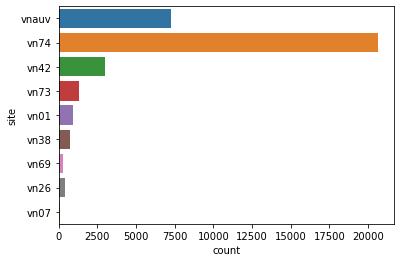

In [7]:
sns.countplot(y="site", data=epoc_df);

## Classement en nombre par département

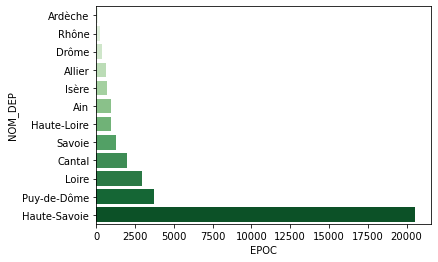

In [28]:
# Classify EPOC count by department
epoc_loc = gpd.sjoin(epoc_df, dept_aura, how="left", op="within").rename(columns={"site": "EPOC"})
epoc_count = epoc_loc.groupby("NOM_DEP").count().sort_values(["EPOC"])
sns.barplot(y="NOM_DEP", x="EPOC", palette="Greens", data=epoc_count.reset_index(drop=False));

<AxesSubplot:>

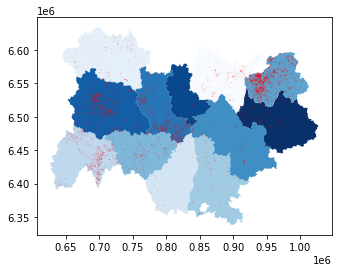

In [10]:
# Buffer and merge EPOCs
epoc_df["geom"] = epoc_df.buffer(EPOC_BUFFER)
epoc_union = gpd.GeoDataFrame(crs="EPSG:2154", geometry=[epoc_df.unary_union])
# Plot merged EPOCs
base = dept_aura.plot(column='NOM_DEP', categorical=True, cmap='Blues')
epoc_union.plot(ax=base, color='red')

## Classement en surface par département

In [11]:
epoc_dept = gpd.overlay(dept_aura, epoc_union, how='intersection')
epoc_dept['epoc_area'] = epoc_dept.area
#epoc_dept.head()

In [12]:
epoc_dept['epoc_pct'] = epoc_dept['epoc_area']/epoc_dept['area']*100
#epoc_dept[['NOM_DEP', 'epoc_pct']]

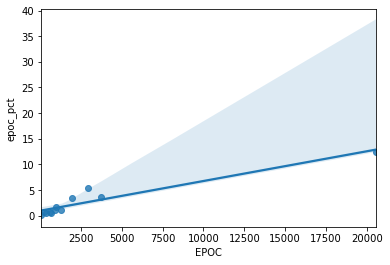

In [42]:
epoc_cs = epoc_dept.set_index("NOM_DEP")[["epoc_pct"]].join(epoc_count[["EPOC"]]).sort_values("EPOC")
sns.regplot(x="EPOC", y="epoc_pct", data=epoc_cs);

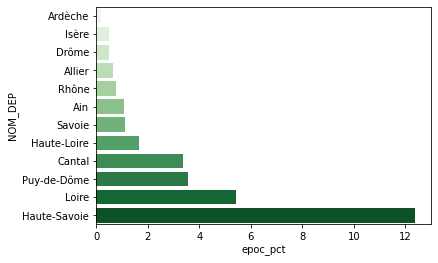

In [14]:
sns.barplot(y="NOM_DEP", x="epoc_pct", palette="Greens", data=epoc_dept.sort_values(['epoc_pct']).reset_index(drop=True));

## Classement en nombre d'EPOC par type de terrain CLC

In [15]:
epoc_clc = gpd.sjoin(epoc_df, clc, how="left", op="within")
epoc_clc.head()

site id_form_universal time_start time_stop full_form version  \
0  vnauv           7_67142   08:50:00  09:00:00         1       0   
1  vnauv           7_67143   09:05:00  09:15:00         1       0   
2  vnauv           7_67144   09:40:00  09:55:00         1       0   
3   vn74         65_710761   09:54:00  10:04:00         1       0   
4  vnauv          65_13953   08:05:00  08:11:00         1       0   

                                            comments protocol  \
0                                               EPOC     None   
1                                               EPOC     None   
2                                               EPOC     None   
3                                               epoc     None   
4  Test EPOC Ortho Photo E : résolution carte ins...     None   

                                                geom  index_right         ID  \
0  POLYGON ((703833.559 6516028.037, 703832.596 6...        15460  FR-258292   
1  POLYGON ((703320.626 6515704.762, 703319.663 6...        15772   FR-90771   
2  POLYGON ((699522.475 6516648.909, 699521.512 6...        15493  FR-272090   
3  POLYGON ((941934.056 6543425.299, 941933.093 6...         9897   FR-25933   
4  POLYGON ((709958.971 6544218.125, 709958.008 6...         9977  FR-162037   

  CODE_18     AREA_HA  
0     313  598.864491  
1     231   33.718858  
2     321  216.523313  
3     112  560.168346  
4     243   63.039761

In [16]:
# Frequence d'EPOC par milieu
epoc_freq = epoc_clc.groupby("CODE_18")["site"].count()/epoc_df["site"].count()*100
#epoc_freq.sum()
# Proportion de surface par type de milieu
clc_freq = clc.groupby("CODE_18")["AREA_HA"].sum()/clc["AREA_HA"].sum()*100
#clc_freq.sum()

In [17]:
clc_nom.index = clc_nom.index.astype(str)
joined_freq = pd.DataFrame(clc_freq).join(clc_nom)
joined_freq = joined_freq.join(pd.DataFrame(epoc_freq)).rename(columns={"AREA_HA": "CLC", "site": "EPOC"})
joined_freq = joined_freq.reset_index(drop=True).melt(id_vars="libelle_fr")
joined_freq

libelle_fr variable     value
0                                Tissu urbain continu      CLC  0.059680
1                             Tissu urbain discontinu      CLC  3.580719
2   Zones industrielles ou commerciales et install...      CLC  0.677915
3   Réseaux routier et ferroviaire et espaces asso...      CLC  0.111651
4                                    Zones portuaires      CLC  0.002976
..                                                ...      ...       ...
61                      Glaciers et neiges éternelles     EPOC       NaN
62                                  Marais intérieurs     EPOC  0.759552
63                                         Tourbières     EPOC  0.017394
64                               Cours et voies d'eau     EPOC  0.344988
65                                        Plans d'eau     EPOC  1.177016

[66 rows x 3 columns]

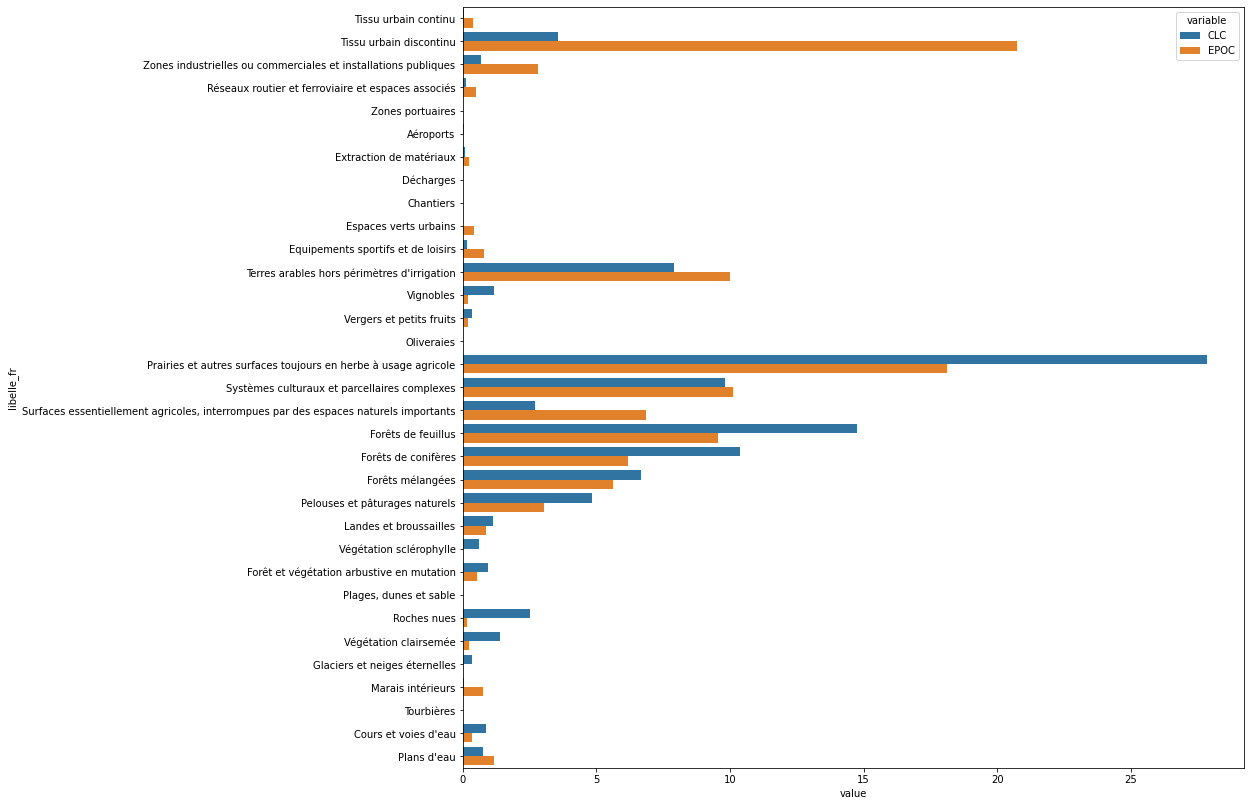

In [18]:
plt.figure(figsize=(14, 14))
sns.barplot(y="libelle_fr", x="value", hue="variable", data=joined_freq);

## Simulation d'EPOC pour analyser la couverture spatiale

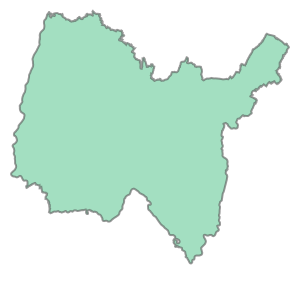

In [60]:
dept_aura.iloc[0]["geometry"]

In [59]:
reg_aura = gpd.GeoDataFrame()
for d in range(len(dept_aura)):
    reg_aura = gpd.overlay(reg_aura, gpd.GeoDataFrame(crs="EPSG:2154", dept_aura.iloc[d]["geometry"]), how="union")
reg_aura.plot()  

ValueError: DataFrame constructor not properly called!

In [50]:
bounds_aura = dept_aura["geometry"].bounds
nb_sim = 500
points_aura = gpd.GeoSeries(crs="EPSG:2154")
for d in range(len(dept_aura)):
    x_min, y_min, x_max, y_max = bounds_aura.iloc[d]
    area = dept_aura['area'].iloc[d]
    nb_cible = int(nb_sim*area/10e9)
    #print(dept_aura['NOM_DEP'].iloc[d], area, nb_cible)
    x = np.random.uniform(x_min, x_max, int(nb_cible*2.5))
    y = np.random.uniform(y_min, y_max, int(nb_cible*2.5))
    rand_points = gpd.GeoSeries(crs="EPSG:2154", data=gpd.points_from_xy(x, y))
    dept_points = rand_points[rand_points.within(dept_aura["geometry"].iloc[d])].iloc[0:nb_cible]
    print(dept_aura['NOM_DEP'].iloc[d], len(dept_points))
    points_aura = points_aura.append(dept_points)

points_aura = gpd.GeoDataFrame({'geometry':points_aura}, crs="EPSG:2154")
#print(points_aura)
# Buffer and merge simulated EPOCs
points_aura["geometry"] = points_aura.buffer(EPOC_BUFFER)
sim_union = gpd.GeoDataFrame(crs="EPSG:2154", geometry=[points_aura.unary_union])
#base = dept_aura.plot(column='NOM_DEP', categorical=True, cmap='Blues')
#sim_union.plot(ax=base, color='red');
# Classify simulated EPOC surface by department
sim_dept = gpd.overlay(dept_aura, sim_union, how='intersection')
sim_dept['epoc_area'] = sim_dept.area
sim_dept.head()
sim_dept['epoc_pct'] = sim_dept['epoc_area']/sim_dept['area']*100
sim_dept[['NOM_DEP', 'epoc_pct']]
#sns.barplot(y="NOM_DEP", x="epoc_pct", palette="Greens", data=sim_dept.sort_values(['epoc_pct']).reset_index(drop=True));

Ain 288
Allier 368
Ardèche 278
Cantal 288
Drôme 327
Isère 393
Loire 239
Haute-Loire 249
Puy-de-Dôme 400
Rhône 162
Savoie 313
Haute-Savoie 229


NOM_DEP  epoc_pct
0            Ain  0.625486
1         Allier  0.623492
2        Ardèche  0.626287
3         Cantal  0.623272
4          Drôme  0.623588
5          Isère  0.625580
6          Loire  0.626383
7    Haute-Loire  0.625021
8    Puy-de-Dôme  0.616793
9          Rhône  0.620374
10        Savoie  0.623529
11  Haute-Savoie  0.620434